In [1]:
! pip install d2l

Looking in indexes: http://mirrors.aliyun.com/pypi/simple


In [2]:
import torch
from IPython import display
from d2l import torch as d2l

In [3]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

/root/miniconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


展开每个图像，将它们视为长度为784的向量。因为数据集有10个类别，所以网络输出维度为10

In [4]:
num_inputs = 784
num_outputs = 10

w = torch.normal(0, 0.01, size=(num_inputs, num_outputs),
                 requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

给定一个矩阵X，可以对所有元素求和

In [5]:
X = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
X.sum(0, keepdim=True), X.sum(1, keepdim=True)

(tensor([[5., 7., 9.]]),
 tensor([[ 6.],
         [15.]]))

实现softmax

In [6]:
def softmax(X):
  X_exp = torch.exp(X)
  partition = X_exp.sum(1, keepdim=True)
  return X_exp / partition # 这里应用了广播机制

将每个元素变成一个非负数，此外，依据概率原理，每行总和为1

In [7]:
x = torch.normal(0, 1, (2,5))
print(f"x: {x}")
x_prob = softmax(x)
print(f"x_prob: {x_prob}")
print(f"x_prob.sum(): {x_prob.sum()}")
print(f"x_prob.sum(1): {x_prob.sum(1)}")

x: tensor([[-0.1312,  0.0988,  0.3473, -0.8219, -1.0723],
        [ 0.4625,  1.1781, -0.4640, -2.2383, -0.1827]])
x_prob: tensor([[0.2099, 0.2642, 0.3387, 0.1052, 0.0819],
        [0.2479, 0.5072, 0.0982, 0.0167, 0.1301]])
x_prob.sum(): 2.000000238418579
x_prob.sum(1): tensor([1., 1.])


实现softmax回归模型

In [8]:
def net(X):
  return softmax(torch.matmul(X.reshape((-1,w.shape[0])), w) + b)

这段代码是一个简单的神经网络的前向传播函数，使用了softmax激活函数。让我一步步解释它：

1. `X` 是输入数据，它通过神经网络的前向传播过程。
2. `X.reshape((-1, w.shape[0]))` 将输入数据 `X` 进行重塑，使得它的形状变为 (-1, w.shape[0])。这里的 `-1` 表示自动计算，保持数据总元素个数不变，而 `w.shape[0]` 表示将 `X` 的第一维（行数）的大小设置为权重矩阵 `w` 的行数。
3. `torch.matmul(X.reshape((-1,w.shape[0])), w)` 执行矩阵乘法，将重塑后的输入数据与权重矩阵 `w` 相乘。
4. 将上述结果与偏置项 `b` 相加，得到一个线性变换的输出。
5. `softmax()` 函数应用于线性变换的输出，将其转换为概率分布。Softmax 操作通常用于多类别分类问题，它可以将原始分数转换为概率分布，使得每个类别的概率值都在 0 到 1 之间，且所有类别的概率之和为 1。
6. 最终，函数返回经过 Softmax 处理的输出。

在这个函数中，`w` 表示权重矩阵，`b` 表示偏置项。这个网络假设输入 `X` 是一个扁平化的向量，通过矩阵乘法与权重相乘，再加上偏置项，最后经过 Softmax 处理得到输出。这种简单的网络结构适用于多类别分类问题。

 创建一个数据y_hat，其中包含2个样本在3个类别的预测概率，使用y作为y_hat中概率的索引

In [9]:
y = torch.tensor([0, 2]) # 两个真实的标号
y_hat = torch.tensor([[0.1, 0.2, 0.6], [0.3, 0.2, 0.5]]) #预测值
y_hat[[0,1], y]

tensor([0.1000, 0.5000])

`y_hat[[0, 1], y]` 是用来索引`y_hat`矩阵的一个操作。在这里，`[0, 1]` 是行索引，`y` 是列索引。

让我们详细解释：

- `y_hat[[0, 1], y]` 中的 `[0, 1]` 是行索引，表示选择矩阵 `y_hat` 的第0行和第1行。
- `y` 是列索引，表示选择每一行中的列。在这个例子中，`y` 是一个包含真实标签的张量，它告诉我们在每一行中应该选择哪一列的元素作为预测值。

考虑例子中的 `y_hat`：

```python
y_hat = torch.tensor([[0.1, 0.2, 0.6], [0.3, 0.2, 0.5]])
```

- 对于第一个行索引 `0`，对应的真实标签是 `y[0] = 0`，因此选择该行的第0列元素（0.1）作为预测值。
- 对于第二个行索引 `1`，对应的真实标签是 `y[1] = 2`，因此选择该行的第2列元素（0.5）作为预测值。

所以，`y_hat[[0, 1], y]` 返回一个包含选择的预测值的张量，即 `[0.1, 0.5]`。这个操作在计算交叉熵损失等分类问题的损失函数时经常使用，用于获取模型对真实标签的预测概率。

实现交叉熵损失函数

In [10]:
def cross_entropy(y_hat, y):
  return -torch.log(y_hat[range(len(y_hat)), y])

cross_entropy(y_hat, y)

tensor([2.3026, 0.6931])

这行代码实现了交叉熵损失的计算。让我解释这个表达式 `-torch.log(y_hat[range(len(y_hat)), y])`：

1. `y_hat[range(len(y_hat)), y]`：这一部分使用了先前提到的索引操作，其中 `range(len(y_hat))` 生成了一个从 0 到 `len(y_hat) - 1` 的列表，作为行索引；而 `y` 是真实标签，作为列索引。这样可以获取对应真实标签位置的预测概率值。

2. `torch.log(...)`：对上述得到的预测概率值进行自然对数（logarithm）运算。

3. `-torch.log(y_hat[range(len(y_hat)), y])`：对取得的对数值取负号。这是因为交叉熵损失的定义中包含一个负号，因此在实现时需要取负以得到正的损失值。

这一行代码的目的是计算交叉熵损失。在分类问题中，交叉熵损失用于衡量模型的预测概率分布与真实标签之间的差异。这里的 `-torch.log(...)` 表达式是交叉熵损失函数中常见的形式，它对每个样本计算了模型对真实标签的预测概率的负对数。

将预测类别与真实y元素进行对比

In [11]:
def accuracy(y_hat, y):
  # 计算预测正确的数量
  if len(y_hat.shape)> 1 and y_hat.shape[1] > 1:
    y_hat = y_hat.argmax(axis=1)
  cmp = y_hat.type(y.dtype) == y
  return float(cmp.type(y.dtype).sum())

accuracy(y_hat, y) / len(y)

0.5

这段代码实现了计算分类模型的准确率。下面是对代码的详细解释：

1. `if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:`：这个条件判断语句检查预测值 `y_hat` 是否是一个矩阵（多类别分类）。如果 `y_hat` 是一个矩阵（即有多个类别的情况），则通过 `argmax(axis=1)` 选择每行中最大元素的索引，以获得模型对每个样本的类别预测。

2. `y_hat = y_hat.argmax(axis=1)`：如果 `y_hat` 是一个矩阵，将其转换为一维张量，其中每个元素表示对应样本的类别预测。

3. `cmp = y_hat.type(y.dtype) == y`：创建一个布尔张量 `cmp`，表示模型预测的类别是否与真实类别相等。这里使用了 `.type(y.dtype)` 来确保比较的数据类型一致。

4. `float(cmp.type(y.dtype).sum())`：计算正确预测的数量。`cmp.type(y.dtype)` 将布尔张量转换为与真实标签相同的数据类型，然后使用 `.sum()` 计算所有正确预测的样本数量。

5. `accuracy(y_hat, y) / len(y)`：最终返回准确率，即正确预测的数量除以总样本数量。这里使用 `len(y)` 获取样本总数。

这个准确率的计算函数适用于二分类和多分类问题。在多分类问题中，预测值 `y_hat` 可能是一个独热编码的概率分布，或者是包含类别索引的一维张量，通过 `argmax` 转换为类别预测。最后，计算正确预测的数量并除以总样本数量，得到准确率。

在PyTorch中，`.dtype` 和 `.type()` 实际上是类似的操作，它们都用于获取或设置张量的数据类型。然而，有一些细微的区别：

1. **`.dtype`**:
   - `.dtype` 是张量的属性，用于获取当前张量的数据类型。
   - 使用方式是直接通过属性获取，例如：`tensor.dtype`。

2. **`.type()`**:
   - `.type()` 是一个方法，它允许你获取或设置张量的数据类型。
   - 使用方式是通过方法调用，例如：`tensor.type(new_dtype)`。

在实际使用中，`.type()` 更为通用，因为它不仅可以用于获取数据类型，还可以用于修改数据类型。例如，如果你想将一个张量的数据类型从 `float32` 改为 `int64`，可以使用 `.type(torch.int64)`。

```python
# 使用 .dtype 获取数据类型
dtype_tensor = torch.tensor([1.0, 2.0, 3.0])
print(dtype_tensor.dtype)  # 输出：torch.float32

# 使用 .type() 获取和修改数据类型
type_tensor = torch.tensor([1.0, 2.0, 3.0])
print(type_tensor.type())  # 输出：torch.FloatTensor
type_tensor = type_tensor.type(torch.int64)
print(type_tensor.type())  # 输出：torch.LongTensor
```

总的来说，`.dtype` 主要用于获取数据类型，而 `.type()` 不仅可以获取，还可以用于修改数据类型。在很多情况下，两者是可以互换使用的。

Accumulator 实例中创建了2个变量，用于分别存储正确预测的数量和预测的总数量

评估在任意模型net的准确率

In [12]:
class Accumulator:
  # 在n个变量熵累加
  def __init__(self, n):
    self.data = [0.0] * n
  def add(self, *args):
    self.data = [a + float(b) for a, b in zip(self.data, args)]
  def reset(self):
    self.data = [0.0] * len(self.data)

  def __getitem__(self, idex):
    return self.data[idex]


这是一个简单的累加器（Accumulator）类，它可以用于累加一系列变量的值。让我解释这个类的各个部分：

1. **`__init__(self, n)`**: 构造函数，初始化累加器对象。`n` 是要累加的变量的数量。创建了一个长度为 `n` 的列表 `self.data`，并将其所有元素初始化为 0.0。

2. **`add(self, *args)`**: 添加值的方法。接受可变数量的参数 `*args`，并将其与累加器中对应位置的值相加。这里使用了 `zip` 函数来同时迭代累加器的数据和传入的参数，然后更新累加器的数据。

3. **`reset(self)`**: 重置方法。将累加器的所有值重置为 0.0。

4. **`__getitem__(self, index)`**: 获取方法。允许通过索引访问累加器中的数据。在这里，你定义了 `__getitem__` 方法，使得可以通过 `accumulator_instance[index]` 的方式获取累加器中特定索引位置的值。

使用示例：

```python
# 创建一个累加器，用于累加三个变量的值
accumulator = Accumulator(3)

# 添加一些值
accumulator.add(1, 2, 3)
accumulator.add(4, 5, 6)

# 打印累加器的数据
print(accumulator.data)  # 输出：[5.0, 7.0, 9.0]

# 通过索引访问累加器的数据
print(accumulator[1])  # 输出：7.0

# 重置累加器
accumulator.reset()
print(accumulator.data)  # 输出：[0.0, 0.0, 0.0]
```

这个类的设计允许你灵活地累加变量的值，重置累加器，并通过索引访问累加器中的数据。

在Python中，双下划线（`__`）用于标识特殊方法或魔术方法（magic methods）。这些方法在类中有特殊的含义，它们会在特定的情况下被自动调用。

1. **`__init__(self, n)`**: 这是一个特殊的初始化方法，用于在创建类的实例时进行初始化。当你创建一个新的对象时，`__init__` 方法会在对象被创建后立即调用。在这里，它用于初始化累加器对象的数据。

2. **`__getitem__(self, index)`**: 这是一个特殊的方法，用于实现通过索引访问对象的功能。当你使用 `object[index]` 的语法时，`__getitem__` 方法会被调用。在这里，它允许你通过索引访问累加器中的数据。

3. **`add(self, *args)`**: 这个方法没有双下划线，因为它是一个自定义的方法，而不是Python中的特殊方法。这是一个普通的实例方法，用于在累加器中添加值。你可以给方法取任何你喜欢的名字，不一定非要使用特殊方法的命名约定。

总的来说，特殊方法用于实现类的特定行为，而自定义方法则是根据类的需求添加的普通方法。在类的设计中，特殊方法通常具有预定义的含义，而自定义方法则根据具体的业务逻辑进行设计。

In [13]:
def evaluate_accuracy(net, data_iter):
  # 计算在指定数据集上模型的精度
  if isinstance(net, torch.nn.Module):
    net.eval() # 将模型设置为评估模式
  metric = Accumulator(2)
  for X, y in data_iter:
    metric.add(accuracy(net(X), y), y.numel())
  return metric[0] / metric[1]

这段代码是一个用于评估模型精度的函数，接受一个神经网络模型 `net` 和一个数据迭代器 `data_iter` 作为输入。让我逐步解释代码：

1. **`if isinstance(net, torch.nn.Module): net.eval()`**: 这个部分首先检查 `net` 是否是 `torch.nn.Module` 类的实例，即检查 `net` 是否是一个PyTorch的神经网络模型。如果是，就调用 `net.eval()` 方法，将模型设置为评估模式。在评估模式下，通常会禁用一些特定于训练的操作，如dropout，以确保评估的一致性。

2. **`metric = Accumulator(2)`**: 创建一个 `Accumulator` 类的实例 `metric`，该累加器用于累加两个值，分别是预测准确的样本数量和总样本数量。这两个值将用于计算最终的模型精度。

3. **`for X, y in data_iter:`**: 这是一个迭代数据集的循环，其中 `X` 是输入数据，`y` 是对应的真实标签。

4. **`metric.add(accuracy(net(X), y), y.numel())`**: 对于每个批次的数据，计算模型在当前批次上的准确率，并将准确率和当前批次的样本数量添加到 `metric` 累加器中。`accuracy` 函数用于计算模型对输入数据的准确率。

5. **`return metric[0] / metric[1]`**: 最后，计算并返回模型在整个数据集上的精度。这是通过将 `metric` 累加器中记录的预测准确的样本数量除以总样本数量来实现的。

总体而言，这个函数的目的是评估给定神经网络模型在指定数据集上的精度。在评估过程中，模型被设置为评估模式，然后遍历数据集，计算准确率，并最终返回整体的模型精度。

`y.numel()` 是 PyTorch 中的一个方法，用于计算张量 `y` 中元素的总数。`numel` 是 "number of elements" 的缩写。

在上下文中，`y` 通常是一个包含标签的张量，而 `y.numel()` 返回的值就是张量中标签的总数。这个值在计算模型在数据集上的准确率时很有用，因为它表示了整个数据集中的样本数量。

在评估模型的精度时，`y.numel()` 用作分母，以计算正确分类的样本在整个数据集中的比例。例如，如果模型正确分类了 80 个样本，而总共有 100 个样本，那么精度就是 80%。这种计算通常用于评估分类模型的性能。

In [14]:
evaluate_accuracy(net, test_iter)

0.1116

softmax回归训练

In [15]:
def train_epoch_ch3(net, train_iter, loss, updater):
    # 将模式设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    
    for X, y in train_iter:
        # 计算梯度并更新
        y_hat = net(X)
        l = loss(y_hat, y)
        
        if isinstance(updater, torch.optim.Optimizer):
            # 使用PyTorch内置的优化器和损失函数
            updater.zero_grad()
            l.backward()
            updater.step()
            metric.add(
                float(l) * len(y), 
                accuracy(y_hat, y),
                y.size().numel()
            )
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
            metric.add(
                float(l.sum()),
                accuracy(y_hat, y),
                y.numel()
            )
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]

这段代码是一个用于训练一个模型的函数，其中包含一个训练周期（epoch）的训练过程。让我逐步解释代码：

1. **`if isinstance(net, torch.nn.Module): net.train()`**: 这部分首先检查 `net` 是否是 `torch.nn.Module` 类的实例，即检查 `net` 是否是一个PyTorch的神经网络模型。如果是，就调用 `net.train()` 方法，将模型设置为训练模式。在训练模式下，通常启用一些特定于训练的操作，如dropout。

2. **`metric = Accumulator(3)`**: 创建一个 `Accumulator` 类的实例 `metric`，该累加器用于累加三个值：累积的损失、累积的准确率、以及累积的样本数量。这些值将在训练过程中用于计算平均损失和准确率。

3. **`for X, y in train_iter:`**: 这是一个迭代训练集的循环，其中 `X` 是输入数据，`y` 是对应的真实标签。

4. **`y_hat = net(X)`**: 使用神经网络模型 `net` 对输入 `X` 进行前向传播，得到预测值 `y_hat`。

5. **`l = loss(y_hat, y)`**: 计算模型的损失，使用预测值 `y_hat` 和真实标签 `y` 之间的差异。`loss` 是损失函数，它衡量模型预测的质量。

6. **`if isinstance(updater, torch.optim.Optimizer): ... else: ...`**: 这是一个条件语句，根据 `updater` 的类型选择不同的更新策略。如果 `updater` 是 `torch.optim.Optimizer` 类的实例，表示使用了PyTorch内置的优化器，如SGD，Adam等，执行优化器的反向传播和参数更新。否则，表示使用自定义的更新策略，通过调用 `updater(X.shape[0])` 进行更新。

7. **`metric.add(...)`**: 将损失、准确率以及样本数量的统计信息添加到 `metric` 累加器中。

8. **`return metric[0] / metric[2], metric[1] / metric[2]`**: 最后，计算并返回训练过程中的平均损失和平均准确率。这是通过将 `metric` 累加器中的损失值除以样本数量得到的。

In [16]:
class Animator:  #@save
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

训练函数

In [17]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):
    animator = Animator(xlabel='epoch', 
                        xlim=[1, num_epochs], 
                        ylim=[0.3,0.9],
                        legend=['train loss', 'train acc', 'test acc']
                       )
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
        

这段代码是一个用于训练神经网络模型的函数 `train_ch3`，它利用一个训练集和一个测试集进行模型的训练和评估。下面是对代码的详细解释：

1. **`animator = Animator(...)`**: 创建了一个 `Animator` 类的实例 `animator`，该实例用于在训练过程中动态地绘制训练损失、训练准确率和测试准确率的变化。

2. **`for epoch in range(num_epochs):`**: 这是一个迭代训练周期（epoch）的循环，循环次数由 `num_epochs` 指定。

3. **`train_metrics = train_epoch_ch3(net, train_iter, loss, updater)`**: 调用 `train_epoch_ch3` 函数进行一个训练周期的训练，并返回训练过程中的损失和准确率。

4. **`test_acc = evaluate_accuracy(net, test_iter)`**: 使用测试集评估训练后的模型，并得到测试集上的准确率。

5. **`animator.add(epoch + 1, train_metrics + test_acc)`**: 将当前训练周期的训练损失、训练准确率和测试准确率添加到 `animator` 实例中，以动态更新图表。

6. **`train_loss, train_acc = train_metrics`**: 解包训练过程中的损失和准确率。

7. **`self.axes[0].cla()`**: 清除当前图表的内容，以便绘制新的数据。

8. **`for x, y, fmt in zip(self.X, self.Y, self.fmts): self.axes[0].plot(x, y, fmt)`**: 绘制图表，将 `animator` 实例中记录的训练损失、训练准确率和测试准确率的变化用不同的线条进行展示。

9. **`self.config_axes()`**: 配置图表的坐标轴标签、限制、刻度等信息。

10. **`display.display(self.fig)`**: 在Jupyter Notebook中显示图表。

11. **`display.clear_output(wait=True)`**: 在Jupyter Notebook中清除当前输出，以便在每个训练周期之间显示最新的图表。

总体而言，这段代码的目的是通过训练周期的迭代动态地展示模型的训练损失、训练准确率和测试准确率的变化情况。 `Animator` 类负责绘制和更新图表，`train_epoch_ch3` 函数用于训练一个周期的模型，而 `evaluate_accuracy` 函数用于评估模型在测试集上的准确率。

小批量随机梯度下降来优化模型的损失函数

In [18]:
lr = 0.1
def updater(batch_size):
    return d2l.sgd([w,b],lr,batch_size)

训练模型10个迭代周期

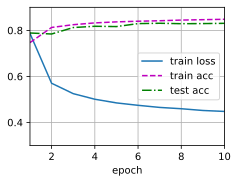

In [19]:
num_ecpochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_ecpochs, updater)

对图像进行分类预测

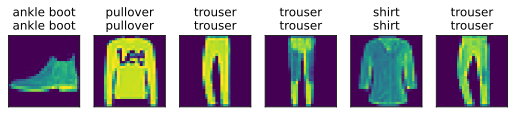

In [20]:
def predict_ch3(net, test_iter, n=6):
    # 预测标签
    for X, y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true + '\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

predict_ch3(net, test_iter)

这段代码用于使用训练好的模型对测试集进行预测，并展示部分预测结果。让我逐步解释代码：

1. **`for X, y in test_iter: break`**: 这个循环迭代测试集一次，取出一个小批次的输入数据 `X` 和对应的真实标签 `y`。`break` 语句用于中断循环，因为我们只需要获取一个批次的数据用于预测。

2. **`trues = d2l.get_fashion_mnist_labels(y)`**: 将真实标签 `y` 转换为对应的类别名称，使用了 `d2l.get_fashion_mnist_labels` 函数，该函数是用来获取Fashion-MNIST数据集的类别标签。

3. **`preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))`**: 使用神经网络模型 `net` 对输入数据 `X` 进行前向传播，然后通过 `argmax(axis=1)` 获取模型预测的类别。再次使用 `d2l.get_fashion_mnist_labels` 将预测的类别转换为类别名称。

4. **`titles = [true + '\n' + pred for true, pred in zip(trues, preds)]`**: 创建一个标题列表，每个标题包含真实标签和模型预测标签，以便在图像展示时显示。

5. **`d2l.show_images(X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])`**: 使用 `d2l.show_images` 函数展示预测结果。这个函数用于显示图像，其中 `X[0:n]` 表示取出前 `n` 个样本，`reshape((n, 28, 28))` 将图像数据重新调整为 `(n, 28, 28)` 的形状。参数 `titles` 用于显示图像的标题。

总体来说，这段代码的目的是展示模型在测试集上的预测结果。它取出一个小批次的测试数据，对这些数据进行预测，并显示真实标签和模型预测标签的对比。